# Diffusion model lab 
# Part 2/2: Analysis of the latent diffusion model 
---
- The goal of this notebook is to study the architecture of the latent diffusion model, with a diagram provided below. 

<img src="img/presentation-ldm.png" alt="main diagram of a LDM model" width="700">

- Since training the model takes approximately 2 hours, we will focus on running a pretrained version.
- The conditional part of this architecture will not be studied

The architecture of an LDM boils down to a U-Net conditioned by a time vector, whose aim is to estimate the noise added to a markov chain process at time _t_.

<img src="img/ldm-unet.png" alt="ldm-unet" width="700">


The training and inference phases can be summarized as follows

<img src="img/ldm-summary.png" alt="ldm-summary" width="600">

In this notebook, is divided in two main parts

1) study of the implementation of the training phase
2) study of the execution of the inference phase

For each of the two parts, you'll essentially be analyzing code and linking it to the architectures/algorithms presented above.


```
Run the following cell to import the necessary libraries to work with the data and PyTorch.
```

In [12]:
# import libraries
import os
import contextlib

import torch
import torch.nn as nn
import monai
from monai import transforms
from monai.apps import MedNISTDataset
from monai.data import Dataset, DataLoader
from monai.data import Dataset as MonaiDataset
from monai.networks.nets import AutoencoderKL, PatchDiscriminator, DiffusionModelUNet
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.layers import Act
from monai.inferers import LatentDiffusionInferer
from monai.networks.schedulers import DDPMScheduler
from monai.utils import first

import numpy as np
from torch.utils.data import random_split
import torchvision
from torchinfo import summary
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.amp import GradScaler, autocast
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.manifold import TSNE
from IPython.display import Image, display
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")


PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4
Monai version: 1.4.0+12.gc1ceea3d


---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading.

```
Run the following cell to download and create Dataset from pytorch
```

In [2]:
# Path to store MedNIST dataset
data_dir = "data/MedNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# Load dataset without reloading if data already exists
train_set = MedNISTDataset(root_dir='data', section="training", download=download, seed=0)
test_set = MedNISTDataset(root_dir='data', section="validation", download=download, seed=0)

Loading dataset: 100%|██████████| 5895/5895 [00:03<00:00, 1759.36it/s]


### Work with only the HAND class images

MedNIST is composed of 8 different types of image: Abdomen from CT, Breast from MRI, Chest from CT, Pulmonary fron X-ray, Hand from X-ray and Head from CT imaging. You may also choose to change the `batch_size` if you want to load more data at a time.

```
Run the following cell to select the type of images you're going to work with.
```

In [3]:
# how many samples per batch to load
batch_size = 64
image_size = 64
train_valid_ratio = 0.8
minv = 0 # min intensity value of each image after rescaling
maxv = 1 # max intensity value of each image after rescaling

labels = ['AbdomenCT','BreastMRI','ChestCT','CXR','Hand','HeadCT']
selected_label = labels[4] # ChestCt to avoid

# keep only the Hand images
train_datalist = [{"image": item["image"], "label": selected_label} for item in train_set.data if item["class_name"] == selected_label]
val_datalist = [{"image": item["image"], "label": selected_label} for item in test_set.data if item["class_name"] == selected_label]

# define the different transforms applied to the image before the generation of the dataset
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

# create the train / test datasets
train_dataset = Dataset(data=train_datalist, transform=train_transforms)
val_dataset = Dataset(data=val_datalist, transform=val_transforms)

# prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

# display the size of the different datasets 
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Training dataset size: 7999
Validation dataset size: 1005


### Visualize a Batch of Training Data

It's always important to check the accuracy of the data before going any further.

```
Run the cell below to display a subset of the training dataset and the size of a batch
```

The image batch size is (64, 1, 64, 64)


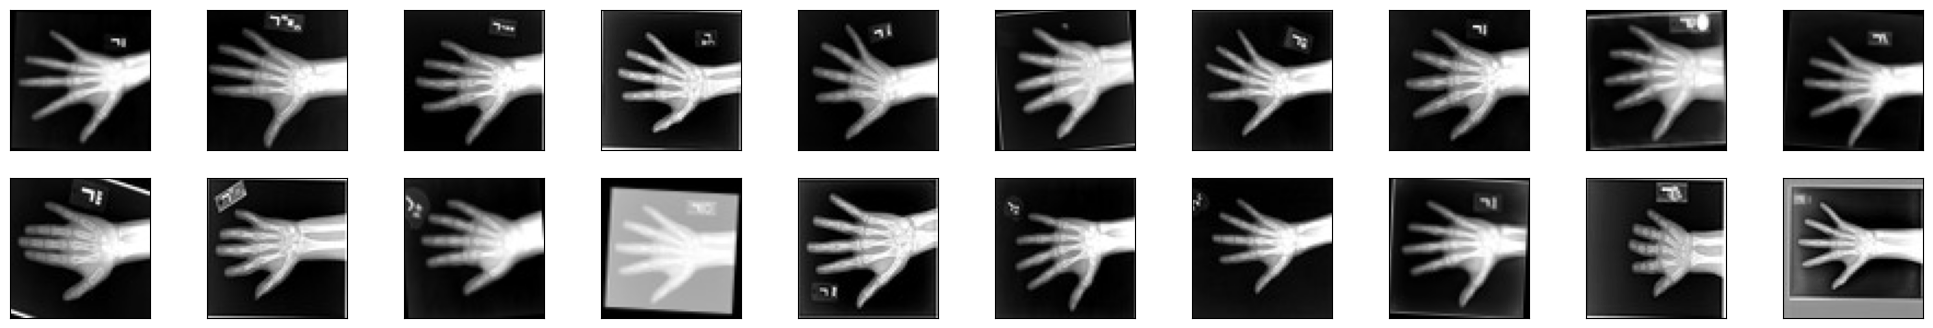

In [4]:
# obtain one batch of training images
dataiter_train = iter(train_loader)
batch = next(dataiter_train)
images = batch["image"]
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

### View an Image in More Detail

```
Run the cell below to display an image with the value of each pixel. This will enable you to check the operations performed by the transforms.Compose() function.
```

The size of an image from the dataset is (64, 64)


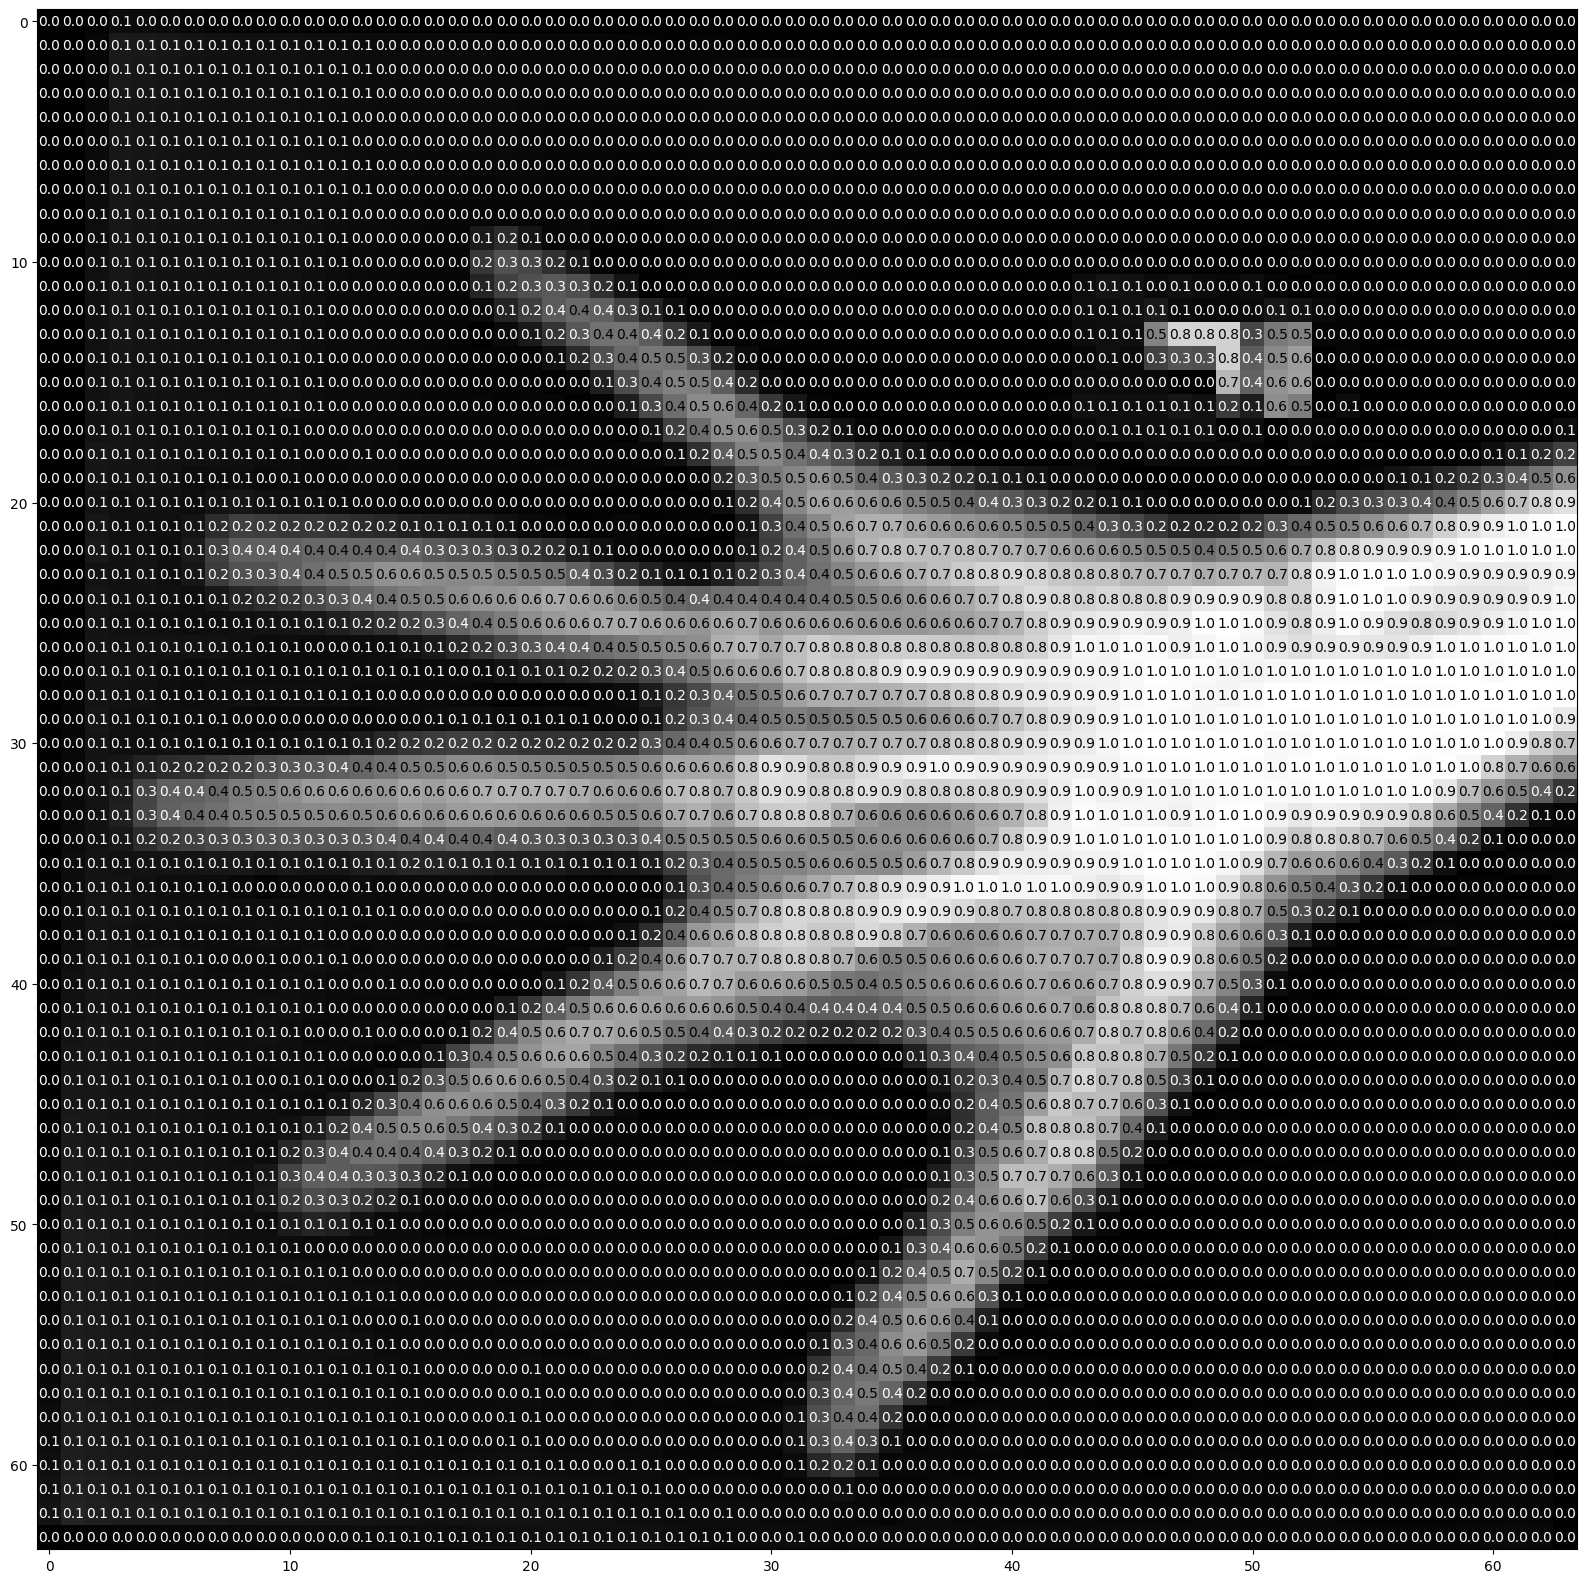

In [5]:
img = np.squeeze(images[0])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (20,20)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the [VAE network architecture](https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/nets/autoencoderkl.py#L564)

We will create a VAE network using an pre-defined network from MONAI library. The parameters chosen are sub-optimal, but reduce the complexity of the architecture and make calculation times short enough to run during the lab.

```
Run the two cells below to define the VAE network (seen as the generator in the adversarial scheme) and visualize the main properties of its architecture.
```

In [6]:
# Parameters
spatial_dims = 2
in_channels = 1
out_channels = 1
channels = (128, 128, 256)
latent_channels = 3
num_res_blocks = 2
norm_num_groups = channels[0]
attention_levels = (False, False, False)
with_encoder_nonlocal_attn = False
with_decoder_nonlocal_attn = False

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# use of the with command line to avoid the automatic display of log information during the instanciation of the class model 
with contextlib.redirect_stdout(None):
    autoencoderkl = AutoencoderKL(
        spatial_dims=spatial_dims,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=channels,
        latent_channels=latent_channels,
        num_res_blocks=num_res_blocks,
        norm_num_groups=norm_num_groups,
        attention_levels=attention_levels,
        with_encoder_nonlocal_attn=with_encoder_nonlocal_attn,
        with_decoder_nonlocal_attn=with_decoder_nonlocal_attn,
    )
    autoencoderkl.to(device)
    
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(autoencoderkl, (1, 1, image_size, image_size), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
AutoencoderKL                            [1, 1, 64, 64]            [1, 1, 64, 64]            --
├─Encoder: 1-1                           [1, 1, 64, 64]            [1, 3, 16, 16]            --
│    └─ModuleList: 2-1                   --                        --                        --
│    │    └─Convolution: 3-1             [1, 1, 64, 64]            [1, 128, 64, 64]          1,280
│    │    └─AEKLResBlock: 3-2            [1, 128, 64, 64]          [1, 128, 64, 64]          295,680
│    │    └─AEKLResBlock: 3-3            [1, 128, 64, 64]          [1, 128, 64, 64]          295,680
│    │    └─AEKLDownsample: 3-4          [1, 128, 64, 64]          [1, 128, 32, 32]          147,584
│    │    └─AEKLResBlock: 3-5            [1, 128, 32, 32]          [1, 128, 32, 32]          295,680
│    │    └─AEKLResBlock: 3-6            [1, 128, 32, 32]          [1, 128, 32, 32]          295,680
│    │ 

- <span style="color:red">Describe the main characteristics of this network.</span>
- <span style="color:red">How many parameters do the network have in total?</span>
- <span style="color:red">What is the size of the latent space?</span>

The code below is commented. It corresponds to the code that has been executed to train the VAE. As you can see, this code is very similar to the one you studied in part 1 of this lab. You don't have to run it, but we've provided it for your information.

In [ ]:
# # define perceptual loss
# perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
# perceptual_loss.to(device)
# perceptual_weight = 0.001

# # define discriminator network
# discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, channels=64, in_channels=1, out_channels=1)
# discriminator = discriminator.to(device)

# # define discriminator loss
# adv_loss = PatchAdversarialLoss(criterion="least_squares")
# adv_weight = 0.01

# # define optimizers
# optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
# optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# # For mixed precision training
# scaler_g = GradScaler()
# scaler_d = GradScaler()

# kl_weight = 1e-6
# max_epochs = 100
# val_interval = 10
# autoencoder_warm_up_n_epochs = 10

# epoch_recon_losses = []
# epoch_gen_losses = []
# epoch_disc_losses = []
# val_recon_losses = []
# intermediary_images = []
# num_example_images = 4

# for epoch in range(max_epochs):
#     autoencoderkl.train()
#     discriminator.train()
#     epoch_loss = 0
#     gen_epoch_loss = 0
#     disc_epoch_loss = 0
#     progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
#     progress_bar.set_description(f"Epoch {epoch}")
#     for step, batch in progress_bar:
#         images = batch["image"].to(device)
#         optimizer_g.zero_grad(set_to_none=True)

#         with autocast("cuda", enabled=True):
#             reconstruction, z_mu, z_sigma = autoencoderkl(images)

#             recons_loss = F.l1_loss(reconstruction.float(), images.float())
#             p_loss = perceptual_loss(reconstruction.float(), images.float())
#             kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
#             kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
#             loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

#             if epoch > autoencoder_warm_up_n_epochs:
#                 logits_fake = discriminator(reconstruction.contiguous().float())[-1]
#                 generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
#                 loss_g += adv_weight * generator_loss

#         scaler_g.scale(loss_g).backward()
#         scaler_g.step(optimizer_g)
#         scaler_g.update()

#         if epoch > autoencoder_warm_up_n_epochs:
#             with autocast("cuda", enabled=True):
#                 optimizer_d.zero_grad(set_to_none=True)

#                 logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
#                 loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
#                 logits_real = discriminator(images.contiguous().detach())[-1]
#                 loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
#                 discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

#                 loss_d = adv_weight * discriminator_loss

#             scaler_d.scale(loss_d).backward()
#             scaler_d.step(optimizer_d)
#             scaler_d.update()

#         epoch_loss += recons_loss.item()
#         if epoch > autoencoder_warm_up_n_epochs:
#             gen_epoch_loss += generator_loss.item()
#             disc_epoch_loss += discriminator_loss.item()

#         progress_bar.set_postfix(
#             {
#                 "recons_loss": epoch_loss / (step + 1),
#                 "gen_loss": gen_epoch_loss / (step + 1),
#                 "disc_loss": disc_epoch_loss / (step + 1),
#             }
#         )
#     epoch_recon_losses.append(epoch_loss / (step + 1))
#     epoch_gen_losses.append(gen_epoch_loss / (step + 1))
#     epoch_disc_losses.append(disc_epoch_loss / (step + 1))

#     if (epoch + 1) % val_interval == 0:
#         autoencoderkl.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for _val_step, batch in enumerate(val_loader, start=1):
#                 images = batch["image"].to(device)

#                 with autocast("cuda", enabled=True):
#                     reconstruction, z_mu, z_sigma = autoencoderkl(images)
#                     # Get the first reconstruction from the first validation batch for visualisation purposes
#                     if _val_step == 1:
#                         intermediary_images.append(reconstruction[:num_example_images, 0])

#                     recons_loss = F.l1_loss(images.float(), reconstruction.float())

#                 val_loss += recons_loss.item()

#         val_loss /= _val_step
#         val_recon_losses.append(val_loss)
#         print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
# progress_bar.close()

# del discriminator
# del perceptual_loss
# torch.cuda.empty_cache()

# torch.save(autoencoderkl, 'autoencoderkl_for_diffusion.pth')  # Save the best model

```
Run the cell below to preload the network with pre-trained weights
```

In [ ]:
autoencoderkl = torch.load("https://creatis.insa-lyon.fr/~bernard/jupyter/pretrained/autoencoderkl_for_diffusion.pth")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


### Visualize Sample Test Results

```
Run the cell below to display reconstructed images taken from the test dataset in the following order: reference image (left) and reconstructed one (right), i.e. the output of the VAE network.
```

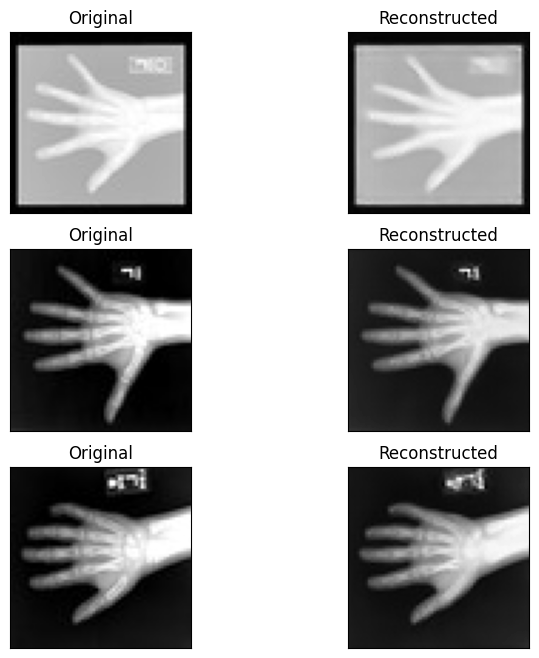

In [9]:
# Prepare next cell
dataiter = iter(val_loader)

# obtain one batch of test images
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data["image"].to(device)
recons, _, _ = autoencoderkl(inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')

---
## Define the [LDM network architecture](https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/nets/diffusion_model_unet.py)

We will create a LDM network using an pre-defined network from MONAI library. The corresponding class will be used: `DiffusionModelUNet`, `DDPMScheduler` and `LatentDiffusionInferer`



### Define [diffusion](https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/nets/diffusion_model_unet.py) model and [scheduler](https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/schedulers/scheduler.py)

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise that is added across the diffusion's model Markov chain.

```
Run the cell below to define the VAE network (seen as the generator in the adversarial scheme) and visualize the main properties of its architecture.
```

In [11]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

- <span style="color:red">Referring to the UNet architecture diagram given in the introduction to this lab, explain what the scheduler object will be used for when training the diffusion network.</span>

The display of the diffusion architecture properties is not straightforward and requires defining a timesteps vector. Therefore, we create a placeholder class below to enable displaying the properties of the unet object.

```
Run the cell below to analyze the architecture of the diffusion model.
```

In [24]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model, timesteps):
        super().__init__()
        self.model = model
        self.timesteps = timesteps

    def forward(self, x):
        # Ajoute une dimension à `timesteps` pour correspondre à `[batch_size]`
        timesteps = self.timesteps.expand(x.size(0))
        return self.model(x, timesteps)

# Ajoutez le wrapper avec un tenseur `timesteps` (valeur fixe, par exemple 10)
timesteps = torch.tensor([10])  # Batch de taille 1
wrapped_unet = WrappedModel(unet, timesteps)

# Affichez le résumé
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(wrapped_unet, (1, 3, 16, 16), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
WrappedModel                                                 [1, 3, 16, 16]            [1, 3, 16, 16]            --
├─DiffusionModelUNet: 1-1                                    [1, 3, 16, 16]            [1, 3, 16, 16]            --
│    └─Sequential: 2-1                                       [1, 128]                  [1, 512]                  --
│    │    └─Linear: 3-1                                      [1, 128]                  [1, 512]                  66,048
│    │    └─SiLU: 3-2                                        [1, 512]                  [1, 512]                  --
│    │    └─Linear: 3-3                                      [1, 512]                  [1, 512]                  262,656
│    └─Convolution: 2-2                                      [1, 3, 16, 16]            [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-4                                   

- <span style="color:red">Describe the main caracteristics of this network.</span>
- <span style="color:red">How many parameters do the network have in total?</span>
- <span style="color:red">Try to match this architectural description with the diagram provided at the beginning of this lab.</span>

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._

```
Run the cell below to compute the scaling factor that will be applied to the standard deviation, ensuring the latent space approximates a Gaussian distribution.
```

In [13]:
check_data = first(train_loader)
with torch.no_grad():
    with autocast("cuda", enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9022284746170044


### [Inferer](https://github.com/Project-MONAI/MONAI/blob/dev/monai/inferers/inferer.py)

We will now define an inferer. This type of class in MONAI takes an auto-encoder, diffusion model, and/or a scheduler, and can be used to perform a signal forward pass for a training iteration, and sample from the model. In the case of a LDM, the corresponding class corresponds to `LatentDiffusionInferer`

```
Run the cell below to define the inferer
```

In [14]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

---
## Training of the diffusion network


The code below is commented. It corresponds to the code that has been executed to train the diffusion model. For information it tooks around 60 min to train it using a GPU card with 32 GB

In [ ]:
# optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

# unet = unet.to(device)
# max_epochs = 200
# val_interval = 40
# epoch_losses = []
# val_losses = []
# scaler = GradScaler()

# for epoch in range(max_epochs):
#     unet.train()
#     autoencoderkl.eval()
#     epoch_loss = 0
#     progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
#     progress_bar.set_description(f"Epoch {epoch}")
#     for step, batch in progress_bar:
#         images = batch["image"].to(device)
#         optimizer.zero_grad(set_to_none=True)
#         with autocast("cuda", enabled=True):
#             z_mu, z_sigma = autoencoderkl.encode(images)
#             z = autoencoderkl.sampling(z_mu, z_sigma)
#             noise = torch.randn_like(z).to(device)
#             timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
#             noise_pred = inferer(
#                 inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
#             )
#             loss = F.mse_loss(noise_pred.float(), noise.float())

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         epoch_loss += loss.item()

#         progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
#     epoch_losses.append(epoch_loss / (step + 1))

#     if (epoch + 1) % val_interval == 0:
#         unet.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for _val_step, batch in enumerate(val_loader, start=1):
#                 images = batch["image"].to(device)

#                 with autocast("cuda", enabled=True):
#                     z_mu, z_sigma = autoencoderkl.encode(images)
#                     z = autoencoderkl.sampling(z_mu, z_sigma)

#                     noise = torch.randn_like(z).to(device)
#                     timesteps = torch.randint(
#                         0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
#                     ).long()
#                     noise_pred = inferer(
#                         inputs=images,
#                         diffusion_model=unet,
#                         noise=noise,
#                         timesteps=timesteps,
#                         autoencoder_model=autoencoderkl,
#                     )

#                     loss = F.mse_loss(noise_pred.float(), noise.float())

#                 val_loss += loss.item()
#         val_loss /= _val_step
#         val_losses.append(val_loss)
#         print(f"Epoch {epoch} val loss: {val_loss:.4f}")

#         # Sampling image during training
#         z = torch.randn((1, 3, 16, 16))
#         z = z.to(device)
#         scheduler.set_timesteps(num_inference_steps=1000)
#         with autocast("cuda", enabled=True):
#             decoded = inferer.sample(
#                 input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
#             )

#         plt.figure(figsize=(2, 2))
#         plt.style.use("default")
#         plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
#         plt.tight_layout()
#         plt.axis("off")
#         plt.show()
# progress_bar.close()


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlist

- <span style="color:red">Take the time to analyse this code and make the link with the different diagrams given at the introduction of this lab.</span>

```
Run the cell below to preload the diffusion network and the inferer with pre-trained weights
```

In [ ]:
unet = torch.load("https://creatis.insa-lyon.fr/~bernard/jupyter/pretrained/diffusion_model_unet.pth")
inferer = torch.load("https://creatis.insa-lyon.fr/~bernard/jupyter/pretrained/inferer_model.pth")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

For information, the following learning curves have been obtained at the end of the training phase.

<img src="img/diffusion-model-loss-curves.png" alt="diffusion model loss curves" width="600">

---
## Evaluate the performance of our trained model on a test dataset

### Visualize Sample Test Results

```
Run the following cell to generate a random latent matrix with values sampled from a Gaussian distribution and produce the corresponding synthetic image.
```


In [21]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 16, 16))
noise = noise.to(device)

- <span style="color:red">Can you comment on the chosen size of the latent matrix?</span>


```
Run the following cell to reverse propagate through the diffusion model over 1000 iterations to generate the corresponding synthetic image.
```

In [22]:
with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|██████████| 1000/1000 [00:09<00:00, 103.89it/s]


```
Run the following cell to decode the latent representations over the reverse process and display the corresponding images
```

(-0.5, 639.5, 63.5, -0.5)

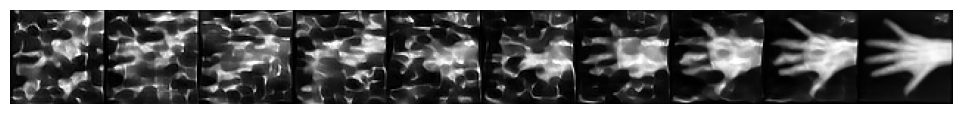

In [19]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
# plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

- <span style="color:red">Run the previous two cells and evaluate the quality of the generated synthetic images.</span>